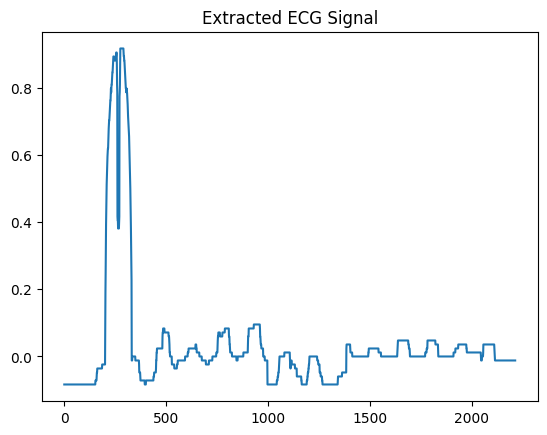

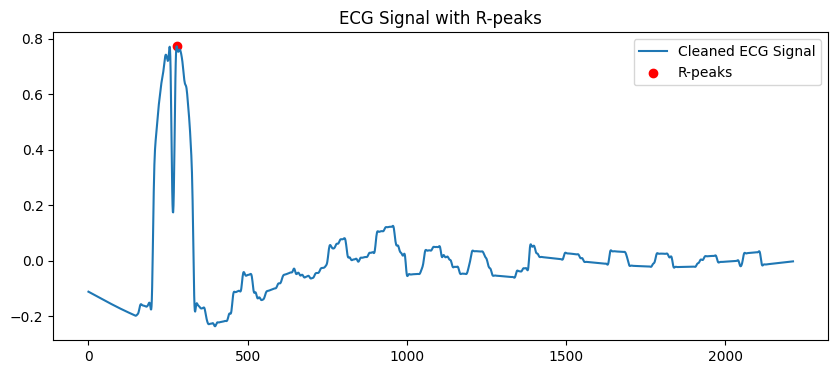

Max ST Elevation: -0.050
Status: Normal


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

# Function to preprocess image and extract clean ECG signal
def extract_ecg_from_image(image_path):
    """
    Extract ECG signal from an image using OpenCV.
    Args:
        image_path (str): Path to the ECG image.
    Returns:
        np.array: Extracted and cleaned signal (y-axis values).
    """
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError("Image not found. Check the path.")

    # Step 1: Remove gridlines and noise
    img = cv2.bitwise_not(img)  # Invert colors
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)  # Reduce noise
    _, img_bin = cv2.threshold(img_blur, 150, 255, cv2.THRESH_BINARY)  # Binarize

    # Morphological operations to remove gridlines
    kernel = np.ones((1, 50), np.uint8)
    img_clean = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)

    # Step 2: Extract signal using vertical projection
    signal = np.sum(img_clean, axis=0)

    # Normalize signal
    signal = signal - np.median(signal)  # Remove DC offset
    signal = signal / (np.max(signal) - np.min(signal))  # Scale between 0 and 1

    # Step 3: Validate the signal
    if np.max(signal) < 0.1:
        raise ValueError("Signal extraction failed. Image may not contain an ECG waveform.")

    # Plot extracted signal
    plt.figure()
    plt.plot(signal)
    plt.title("Extracted ECG Signal")
    plt.show()

    return signal

# Function to apply a bandpass filter
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Function to detect R-peaks and analyze ST-segment
def detect_heart_attack(ecg_signal, sampling_rate=500, elevation_threshold=0.2, depression_threshold=0.1):
    """
    Detect R-peaks and check ST-segment elevation and depression.
    Args:
        ecg_signal (array): Input ECG signal.
        sampling_rate (int): Sampling rate in Hz.
        elevation_threshold (float): Threshold for ST-segment elevation.
        depression_threshold (float): Threshold for ST-segment depression.
    """
    # Step 1: Bandpass filter the signal
    ecg_cleaned = bandpass_filter(ecg_signal, 0.5, 50, sampling_rate)

    # Step 2: Detect R-peaks with adaptive height threshold
    peak_height = 0.6 * np.max(ecg_cleaned)
    r_peaks, _ = find_peaks(ecg_cleaned, height=peak_height, distance=int(0.6 * sampling_rate))

    # Step 3: Analyze ST-segment
    st_elevation = []
    for r_peak in r_peaks:
        st_start = int(r_peak + 0.06 * sampling_rate)
        st_end = int(r_peak + 0.08 * sampling_rate)

        if st_end < len(ecg_cleaned):
            st_level = np.mean(ecg_cleaned[st_start:st_end])
            baseline = np.mean(ecg_cleaned[r_peak - 40:r_peak - 10])
            elevation = st_level - baseline
            st_elevation.append(elevation)

    # Step 4: Classify the signal
    max_elevation = max(st_elevation) if st_elevation else 0

    # Classify based on the ST-elevation
    if max_elevation > elevation_threshold:
        status = "Heart Attack Detected (ST Elevation)"
    elif max_elevation > depression_threshold:
        status = "Early Heart Attack Detected (ST Elevation)"
    else:
        status = "Normal"

    # Plot Results
    plt.figure(figsize=(10, 4))
    plt.plot(ecg_cleaned, label="Cleaned ECG Signal")
    plt.scatter(r_peaks, ecg_cleaned[r_peaks], color='red', label="R-peaks")
    plt.title("ECG Signal with R-peaks")
    plt.legend()
    plt.show()

    # Output
    print(f"Max ST Elevation: {max_elevation:.3f}")
    print(f"Status: {status}")

# Load and process ECG image
#image_path = "/content/drive/MyDrive/ECG Data/Myocardial Infarction Patients/MI(102).jpg"
#image_path="/content/drive/MyDrive/ECG Data/Myocardial Infarction Patients/MI(126).jpg"
#image_path="/content/drive/MyDrive/ECG Data/Myocardial Infarction Patients/MI(1).jpg"
image_path="/content/drive/MyDrive/ECG Data/Normal Person/Normal(100).jpg"
try:
    ecg_signal = extract_ecg_from_image(image_path)
    detect_heart_attack(ecg_signal)
except Exception as e:
    print(f"Error: {e}")
